In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.sparse import csc_matrix
from sklearn.datasets import load_svmlight_file

from optimizers import Nesterov, Sgd, Shuffling
from loss import LogisticRegressionLoss
from utils import get_trace, relative_round

In [11]:
import matplotlib
sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = (8, 6)

## Get data and set all parameters

In [12]:
dataset = 'w8a.txt'
A, b = load_svmlight_file('./datasets/' + dataset)

loss = LogisticRegressionLoss(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness()
l2 = L / np.sqrt(n)
loss.l2 = l2
x0 = csc_matrix((dim, 1))
n_epoch = 600
batch_size = 512
n_seeds = 2
stoch_it = 250 * n // batch_size
trace_len = 300
trace_path = f'./results/log_reg_{dataset}_l2_{relative_round(l2)}/'

## Run the methods

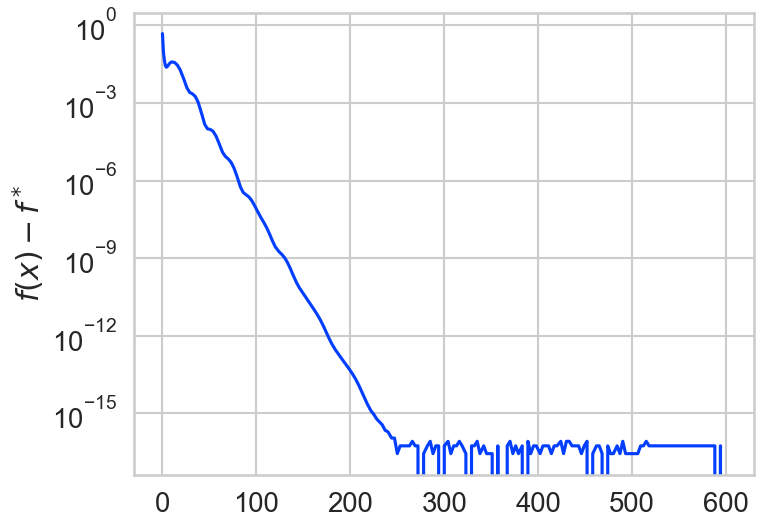

In [13]:
nest_str_trace = get_trace(f'{trace_path}nest_str', loss)
if not nest_str_trace:
    nest_str = Nesterov(loss=loss, it_max=n_epoch, mu=l2, strongly_convex=True)
    nest_str_trace = nest_str.run(x0=x0)
    nest_str_trace.compute_loss_of_iterates()
    nest_str_trace.save('nest_str', trace_path)
    nest_str_trace.plot_losses()
    plt.yscale('log')
f_opt = np.min(nest_str_trace.loss_vals)
x_opt = nest_str_trace.xs[-1]

In [14]:
rr_trace = get_trace(f'{trace_path}rr', loss)
if not rr_trace:
    rr_lr0 = 1 / l2
    rr_decay_coef = l2 / 3
    rr_lr_max = 1 / loss.batch_smoothness(batch_size)
    rr = Shuffling(loss=loss, lr0=rr_lr0, lr_max=rr_lr_max, lr_decay_coef=rr_decay_coef, 
                   it_max=stoch_it, n_seeds=n_seeds, batch_size=batch_size, trace_len=trace_len)
    rr_trace = rr.run(x0=x0)
    rr_trace.convert_its_to_epochs(batch_size=batch_size)
    rr_trace.compute_loss_of_iterates()
    rr_trace.save('rr', trace_path)

In [15]:
so_trace = get_trace(f'{trace_path}so', loss)
if not so_trace:
    so_lr0 = 1 / l2
    so_decay_coef = l2 / 3
    so_lr_max = 1 / loss.batch_smoothness(batch_size)
    so = Shuffling(loss=loss, lr0=so_lr0, lr_max=so_lr_max, lr_decay_coef=so_decay_coef, 
                   it_max=stoch_it, n_seeds=n_seeds, batch_size=batch_size, steps_per_permutation=np.inf, trace_len=trace_len)
    so_trace = so.run(x0=x0)
    so_trace.convert_its_to_epochs(batch_size=batch_size)
    so_trace.compute_loss_of_iterates()
    so_trace.save('so', trace_path)

In [16]:
sgd_trace = get_trace(f'{trace_path}sgd_no_miss', loss)
sgd_perm = np.random.permutation(n)
loss_sgd = LogisticRegressionLoss(A[sgd_perm], b[sgd_perm], l1=0, l2=l2)
if not sgd_trace:
    sgd_lr0 = 1 / l2
    sgd_decay_coef = l2 / 2
    sgd_lr_max = 1 / loss.batch_smoothness(batch_size)
    sgd = Sgd(loss=loss_sgd, lr_max=sgd_lr_max, lr0=sgd_lr0, lr_decay_coef=sgd_decay_coef, 
              it_max=stoch_it, n_seeds=1, batch_size=batch_size, avoid_cache_miss=True, trace_len=trace_len)
    sgd_trace = sgd.run(x0=x0)
    sgd_trace.convert_its_to_epochs(batch_size=batch_size)
    sgd_trace.compute_loss_of_iterates()
    sgd_trace.save('sgd_no_miss', trace_path)

## Plot the convergence results

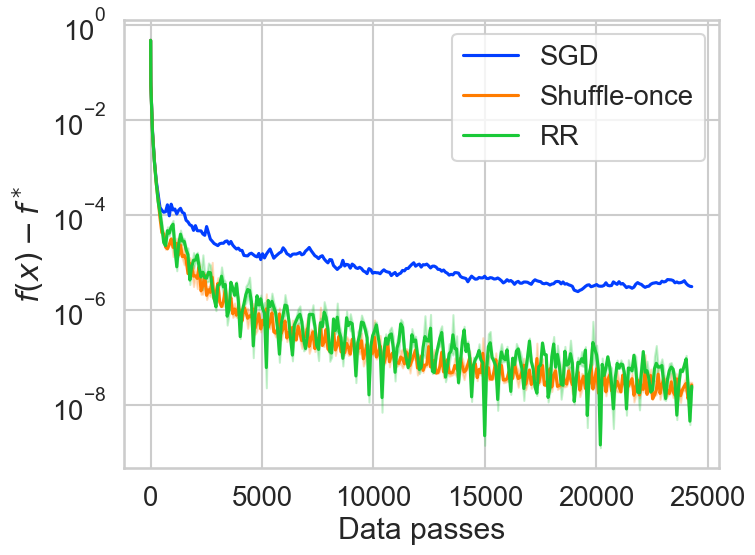

In [17]:
traces = [sgd_trace, so_trace, rr_trace]
labels = ['SGD', 'Shuffle-once', 'RR']
for trace, label in zip(traces, labels):
    trace.plot_losses(f_opt=f_opt, label=label)
plt.yscale('log')
plt.legend()
plt.xlabel('Data passes')
plt.tight_layout()


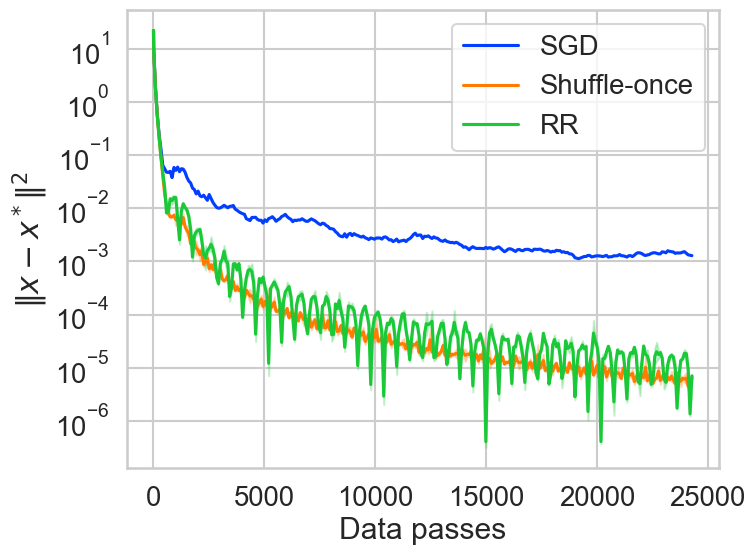

In [18]:
for trace, label in zip(traces, labels):
    trace.plot_distances(x_opt=x_opt, label=label)
plt.yscale('log')
plt.legend()
plt.xlabel('Data passes')
plt.tight_layout()